# Многомерная модель на LSTM

In [65]:
import os
import glob
import datetime
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Библиотека [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation") для загрузки рыночных данных из различных источников в формате **pandas**:

In [67]:
from pandas_datareader import data as pdr

[Python wrapper](https://github.com/mrjbq7/ta-lib "mrjbq7/ta-lib: Python wrapper for TA-Lib (http://ta-lib.org/).") для библиотеки технического анализа [`TA-Lib`](http://ta-lib.org "TA-Lib : Technical Analysis Library") (индикаторы и т.п.):

In [68]:
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib
# pip install TA_Lib‑0.4.17‑cp37‑cp37m‑win_amd64.whl
# pip install TA-Lib

import talib

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

# from tqdm import tqdm
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)

In [70]:
import tensorflow as tf
# tf.test.is_gpu_available()
tf.__version__

'2.0.0'

Недавно официально вышел релиз [`tensorflow 2.0`](https://www.tensorflow.org/guide/effective_tf2 "Effective TensorFlow 2 &nbsp;|&nbsp; TensorFlow Core") (стал доступен в [Anaconda](https://anaconda.org/anaconda/tensorflow-gpu "Tensorflow Gpu :: Anaconda Cloud")). Там [`keras`](https://www.tensorflow.org/guide/keras "Keras &nbsp;|&nbsp; TensorFlow Core") теперь немного по другому импортируется.

In [71]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Flatten, ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Nadam

Моя маленькая библиотека для хранения рыночных данных, индикаторов и работы со скользящими окнами временных рядов:

In [93]:
from mdp.MarketData import MarketData
from mdp.MovingWindowFeatures import MovingWindowFeatures
from mdp.DatasetGenerator import RegressionGenerator, ClassificationGenerator, MultitaskGenerator
from mdp import Utils, PlotHelpers

In [95]:
# поскольку работа над классами идёт параллельно, то приходится иногда перезагружать модули
import importlib

import mdp
importlib.reload(mdp.MarketData)
importlib.reload(mdp.MovingWindowFeatures)
importlib.reload(mdp.DatasetGenerator)
importlib.reload(mdp.Utils)
importlib.reload(mdp.PlotHelpers);

# *Параметры*

In [84]:
INSTRUMENT = 'MSFT'
DATASET_START_FROM = '2009-01-01'
WINDOW_SIZE = 20
BATCH_SIZE = 32
SELECTED_FEATUES = None # все признаки: доходности по 4 видам цен, объём торгов, индикаторы
# SELECTED_FEATUES = ['c_log_ret']
TEST_SPLIT = '2019-01-03'
FORCE_TRAIN = False

# *Исходные данные*

Открытые рыночные данные будем загружать через [`pandas_datareader`](https://pandas-datareader.readthedocs.io/en/latest/index.html "pandas-datareader &mdash; pandas-datareader documentation"). В качестве источника данных мне понравился сервис [Tiingo](https://www.tiingo.com "Stock Market Tools | Tiingo"). В частности, его удобство в том, что он сразу выдаёт скорректированные (corporate actions adjusted) значения для всей "свечи" (четвёрки цен), а не только для цены закрытия.

In [85]:
instr_df = pdr.get_data_tiingo(INSTRUMENT, api_key=os.environ.get('TIINGO_API_KEY'), start=DATASET_START_FROM)

instr_df

close    high      low      open    volume  \
symbol date                                                                     
MSFT   2009-01-02 00:00:00+00:00   20.33   20.40   19.370   19.5328  50084000   
       2009-01-05 00:00:00+00:00   20.52   20.67   20.060   20.2000  61475200   
       2009-01-06 00:00:00+00:00   20.76   21.00   20.610   20.7500  58083400   
       2009-01-07 00:00:00+00:00   19.51   20.29   19.480   20.1900  72709900   
       2009-01-08 00:00:00+00:00   20.12   20.19   19.550   19.6300  70255400   
...                                  ...     ...      ...       ...       ...   
       2019-12-06 00:00:00+00:00  151.75  151.87  150.270  150.9900  16410400   
       2019-12-09 00:00:00+00:00  151.36  152.21  150.910  151.0700  16741350   
       2019-12-10 00:00:00+00:00  151.13  151.89  150.765  151.2900  16481060   
       2019-12-11 00:00:00+00:00  151.70  151.87  150.330  151.5400  18860001   
       2019-12-12 00:00:00+00:00  153.24  153.44  151.020  151.6500  24645366   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
MSFT   2009-01-02 00:00:00+00:00   15.633333   15.687162   14.895114   
       2009-01-05 00:00:00+00:00   15.779439   15.894786   15.425709   
       2009-01-06 00:00:00+00:00   15.963994   16.148549   15.848647   
       2009-01-07 00:00:00+00:00   15.002771   15.602574   14.979702   
       2009-01-08 00:00:00+00:00   15.471848   15.525676   15.033530   
...                                      ...         ...         ...   
       2019-12-06 00:00:00+00:00  151.750000  151.870000  150.270000   
       2019-12-09 00:00:00+00:00  151.360000  152.210000  150.910000   
       2019-12-10 00:00:00+00:00  151.130000  151.890000  150.765000   
       2019-12-11 00:00:00+00:00  151.700000  151.870000  150.330000   
       2019-12-12 00:00:00+00:00  153.240000  153.440000  151.020000   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
MSFT   2009-01-02 00:00:00+00:00   15.020304   50084000      0.0          1.0  
       2009-01-05 00:00:00+00:00   15.533366   61475200      0.0          1.0  
       2009-01-06 00:00:00+00:00   15.956304   58083400      0.0          1.0  
       2009-01-07 00:00:00+00:00   15.525676   72709900      0.0          1.0  
       2009-01-08 00:00:00+00:00   15.095048   70255400      0.0          1.0  
...                                      ...        ...      ...          ...  
       2019-12-06 00:00:00+00:00  150.990000   16410400      0.0          1.0  
       2019-12-09 00:00:00+00:00  151.070000   16741350      0.0          1.0  
       2019-12-10 00:00:00+00:00  151.290000   16481060      0.0          1.0  
       2019-12-11 00:00:00+00:00  151.540000   18860001      0.0          1.0  
       2019-12-12 00:00:00+00:00  151.650000   24645366      0.0          1.0  

[2756 rows x 12 columns]

## Загрузка данных и вычисление индикаторов

Здесь открытый вопрос, какой длины историю разумно брать.
Для дневных цен, возможно, брать слишком длинную историю смысла нет, потому что торговые паттерны в прошлом, предположительно, отличаются от более современных. В то же время, если бы у нас были доступны, допустим, поминутные данные, то, возможно, в этом случае имело бы смысл брать как можно более длинную историю (в смысле числа интервалов). Но тут ещё, конечно, следует учитывать вычислительную сложность и скорость обучения (всё-таки это учебная задача).

In [86]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=DATASET_START_FROM)

## Целевая переменная
В качестве целевой переменной будет использоваться не сама цена закрытия, а логарифмическая доходность, которая вычисляется как натуральный логарифм отношения текущей цены к цене предыдущего дня: $\text{Return} = \ln\bigl(\frac{\text{Price}{}_t}{\text{Price}_{t-1}}\bigr)$.

Как уже стало ясно, мы здесь попробуем построить многомерную модель. То есть будем пытаться прогнозировать значение временно́го ряда не только на основе предыдущих значений этого же ряда, но также и других, связанных с ним рядов: другие цены (доходности), объем торгов, технические индикаторы. То есть исходим из предположения, что эти признаки также позволяют прогнозировать целевую цену (по крайней мере, сторонники технического анализа считают именно так).

Ниже выведен список временны́х рядов, которые получены из исходных данных (дневных цен) и будут использоваться для создания признаков обучающей выборки: логарифмические доходности, объём торгов (volume) и различные технические индикаторы.

In [87]:
instr.feature_names

['v',
 'o_log_ret',
 'h_log_ret',
 'l_log_ret',
 'c_log_ret',
 'ema14',
 'ema30',
 'macd',
 'macd_signal',
 'rsi14',
 'bband20_upper',
 'bband20_middle',
 'bband20_lower',
 'willr14']

## Стандартизация?

Ещё отдельный и неоднозначный вопрос - это стандартизация данных. Очевидно, *$Z$-score normalization* к нестационарному временно́му ряду целиком применять бессмысленно. В то же время какую-то стандартизацию, наверное, сделать желательно, потому что не все ряды одинакового масштаба (например, доходности, очевидно, отличаются от индикаторов, которые, в свою очередь отличаются от объёмов).

В то время как сами цены нестационарны (присутствует очевидный тренд), но, как показано ниже, переход к логарифмическим доходностям позволил сделать соответствующие ряды стационарными (но не факт, что это получится для любого ряда цен, потому что бывают такие явления, как _volatility clustering_ и т.п.).

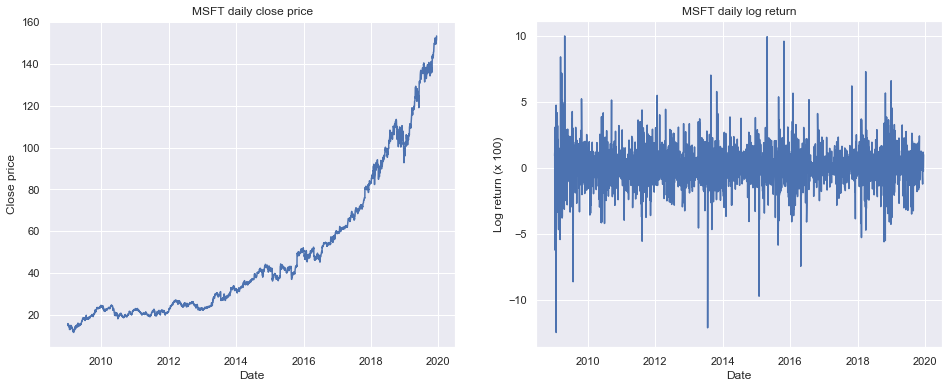

In [88]:
def plot_close_price_returns(market_data):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    def plot_ax(ax, title, x, xlabel, y, ylabel):
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)        
        ax.tick_params(axis='x', rotation=0)
        ax.plot(x, y)
        
    plot_ax(ax[0], f'{market_data.instrument} daily close price',
            market_data.timestamps, 'Date', 
            market_data.c, 'Close price')

    plot_ax(ax[1], f'{market_data.instrument} daily log return',
            market_data.timestamps[1:], 'Date', 
            100 * market_data.c_log_ret[1:], 'Log return (x 100)')
    
plot_close_price_returns(instr)

Итак, исходный ряд цен, очевидно, нестационарен:

In [89]:
Utils.adf_stationarity_test(instr.c[1:], print_results=True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         4.296884
P-Value                    1.000000
# Lags Used                8.000000
# Observations Used     2746.000000
Critical Value (1%)       -3.432734
Critical Value (5%)       -2.862593
Critical Value (10%)      -2.567331
dtype: float64


(1.0, False)

При этом ряд логарифмических доходностей уже стационарен:

In [90]:
Utils.adf_stationarity_test(instr.c_log_ret[1:], print_results=True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.680514e+01
P-Value                 1.211457e-29
# Lags Used             1.000000e+01
# Observations Used     2.744000e+03
Critical Value (1%)    -3.432735e+00
Critical Value (5%)    -2.862594e+00
Critical Value (10%)   -2.567331e+00
dtype: float64


(1.2114571267185977e-29, True)

Тем не менее, такую модификацию (переход к логарифмическим доходностям) можно провести только с рядами цен. Индикаторы уже имеют иную природу, так что и бороться с нестационарностью там, скорее всего, придётся иными способами (дифференцирование?).

Поэтому, в качестве компромиссного решения (возможно, не совсем методологически правильного), я решил делать стандартизацию в пределах скользящего окна, исходя из допущения, что внутри окна данные можно считать приблизительно одинаково распределёнными для любого признака

## Индикаторы

Для примера построим график [MACD](https://www.investopedia.com/terms/m/macd.asp "Moving Average Convergence Divergence – MACD Definition").

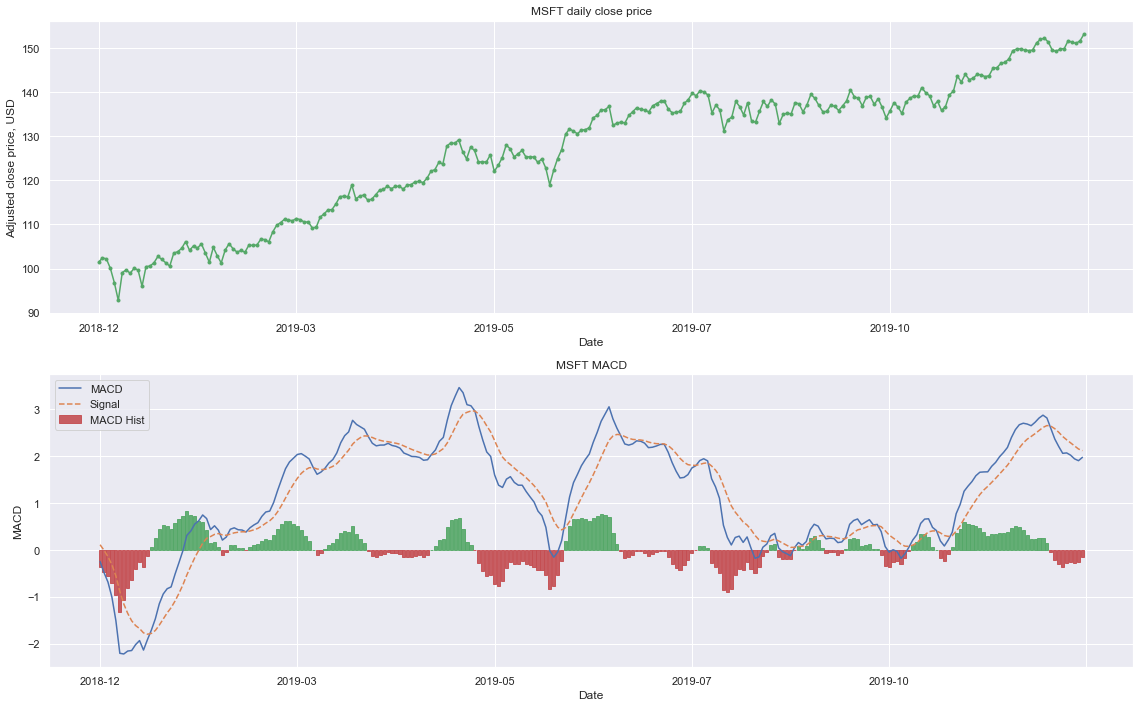

In [96]:
PlotHelpers.plot_macd(instr, 250)

## Признаки - скользящие окна
В качестве самих признаков будут использоваться скользящие окна по временны́м рядам. Целевой переменной при этом всегда будет значение доходности по цене закрытия для следующего периода. То есть, если у нас, допустим, размер окна 14 дней, то всегда будем прогнозировать цену на 15-й день (этот сдвиг прогноза настраивается, но по умолчанию он равен 1).

Особенность реализации в том, что данные для скользящих окон не копируются. Вместо этого используется [возможность `numpy`](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/ "IPython Cookbook - 4.6. Using stride tricks with NumPy") наложить произвольный *view* на данные исходного массива (реализовано в функции [`numpy.lib.stride_tricks.as_strided`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.lib.stride_tricks.as_strided.html "numpy.lib.stride_tricks.as_strided &mdash; NumPy v1.17 Manual")). В теории это может быть полезно для случая очень большого объёма данных и позволит оптимально использовать доступную оперативную память.

In [97]:
mwf = MovingWindowFeatures.create(instr, window_size=WINDOW_SIZE, selected_features=SELECTED_FEATUES)

len(instr), len(mwf), mwf.features.shape

(2756, 2736, (2736, 20, 14))

Проверка, что скользящие окна соответствуют исходным данным.

Возьмём произвольный признак и произвольное окно (строка #**41**). Проверим, что данные в точности совпадают:

In [98]:
def check_data(mwf, row):
    col = np.random.randint(mwf.features.shape[-1])
    feature = mwf.feature_names[col]
    check = (getattr(mwf.market_data, feature)[row:row + mwf.window_size ] == mwf.features[row, :, col]).all()
    assert check
    return feature, check

check_data(mwf, 41)

('ema30', True)

Продолжая пример с окном размера 14 выше, учитывая, что всего сейчас 15 временны́х рядов (включая сам ряд доходностей по закрытию), то единичным сэмплом будет матрица размером $(14, 15)$ (что в итоге и станет `input_shape` входного слоя сети).

Для обучения я решил использовать метод [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0"). Опять же, такой подход в теории лучше масштабируется на потенциально большой объём данных (которые можно было бы, например, считывать из файла). В данном случае, конечно, генератор просто итерируется по подготовленным ранее массивам со скользящими окнам. То есть за один раз генератор возвращает куб размером *(batch_size; window; n_features)*.

Разделение на обучающую и тестовую выборку проводится по обычному для временны́х рядов принципу: начальная часть ряда для обучения, завершающая - для валидации и теста. В данном случае: данные до 2019 года - для обучения, 2019 год - валидация и тест.

In [99]:
train_gen, test_gen = RegressionGenerator.create_train_test(mwf, batch_size=BATCH_SIZE,
                                                            test_split=TEST_SPLIT, scale=True)

Следующие числа соответствуют значению параметра `steps_per_epoch` метода [`fit_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit_generator "tf.keras.layers.SimpleRNN &nbsp;|&nbsp; TensorFlow Core r2.0") - то есть это число батчей, которые генератор выдаст за одну эпоху обучения (если класс генератора поддерживает метод `len()`, то данный параметр можно не указывать).

In [100]:
len(train_gen), len(test_gen)

(77, 8)

Как уже было отмечено, один сэмпл данных представляет собой матрицу размером *(длина окна; число признаков)*

In [101]:
train_gen.get_input_shape()

(20, 14)

## Baseline

### Регрессия

***Случайное блуждание***: прогноз - следующее значение равно предыдущему, то есть доходность - постоянная и равная 0.

In [110]:
pred_log_ret = np.zeros(test_gen.stop_ix - test_gen.start_ix)

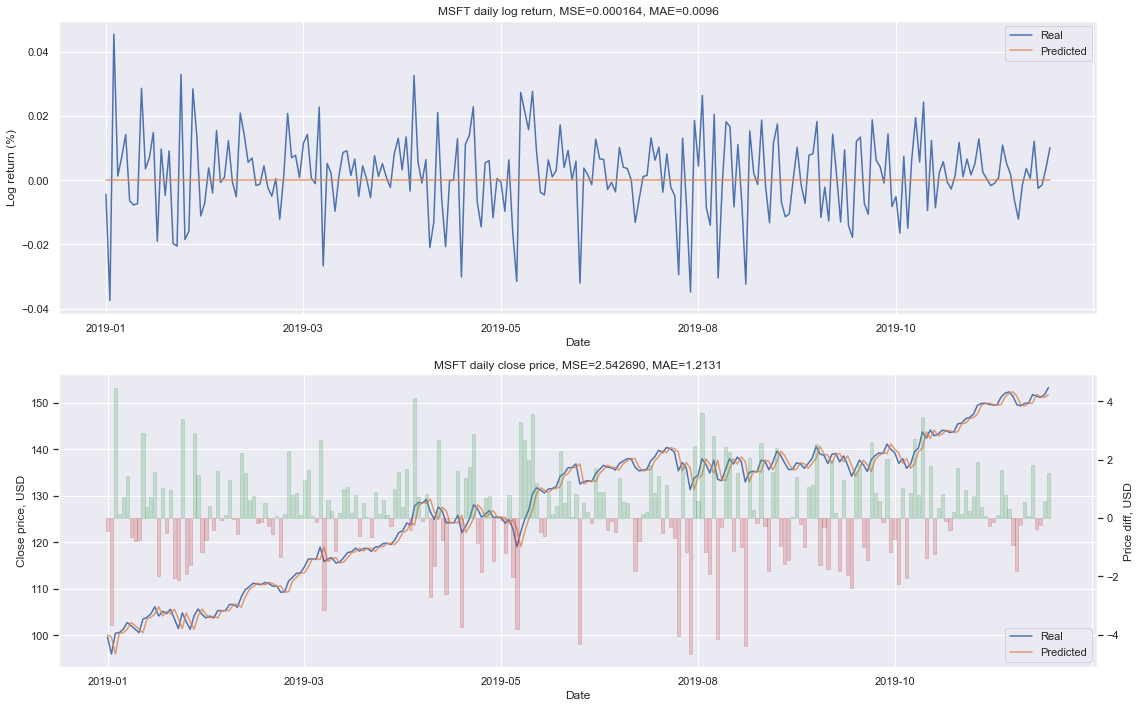

In [111]:
PlotHelpers.plot_regr_predictions(instr, pred_log_ret)

## Классификация

Просто подбрасываем монету.

In [112]:
true_direction = mwf.get_target_direction(mwf.target[-(test_gen.stop_ix - test_gen.start_ix):])

pred_direction_proba = np.random.uniform(size=len(true_direction))
predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

In [113]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

((array([0, 1]), array([ 99, 141], dtype=int64)),
 (array([0, 1]), array([118, 122], dtype=int64)))

In [114]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.43      0.52      0.47        99
           1       0.61      0.52      0.56       141

    accuracy                           0.52       240
   macro avg       0.52      0.52      0.52       240
weighted avg       0.53      0.52      0.52       240



In [115]:
confusion_matrix(true_direction, predicted_direction)

array([[51, 48],
       [67, 74]], dtype=int64)

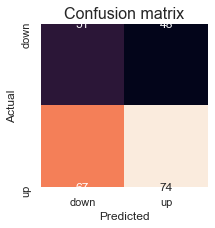

array([[0.43220339, 0.39344262],
       [0.56779661, 0.60655738]])

In [116]:
PlotHelpers.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

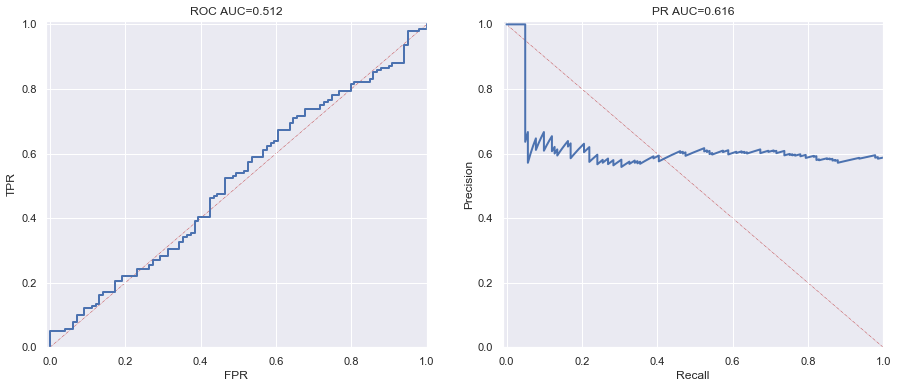

In [117]:
PlotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

# *Модели*

По идее, рекуррентные сети по смыслу должны подходить для обнаружения зависимостей во временны́х рядах. Поэтому для начала попробуем модель с двумя слоями [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM "tf.keras.layers.LSTM &nbsp;|&nbsp; TensorFlow Core r2.0").

In [ ]:
def build_lstm_layers(input_shape, latent_dim=[16, 32]):
    # формат входа: наша матрица (окно; признак)
    inp = Input(input_shape, name='input')

    # стекаем два уровня LSTM
    lstm = LSTM(latent_dim[0], return_sequences=True, 
                    recurrent_dropout=0.25, dropout=0.5, 
                    bias_initializer='he_uniform',
                    bias_regularizer=L1L2(0.01, 0.01),
                    kernel_regularizer=L1L2(0.01, 0.01),
                    recurrent_regularizer=L1L2(0.01, 0.01)
               )(inp)

    lstm = LSTM(latent_dim[1], return_sequences=True,
                    recurrent_dropout=0.25, dropout=0.5,
                    bias_initializer='he_uniform',
                    bias_regularizer=L1L2(0.01, 0.01),
                    kernel_regularizer=L1L2(0.01, 0.01),
                    recurrent_regularizer=L1L2(0.01, 0.01)
               )(lstm)
    
    lstm = Flatten()(lstm)
    
    return inp, lstm

#### Пути:

In [ ]:
model_path_root = 'models'
model_type_name = 'lstm'

def make_model_save_dir(path_root, type_name, class_name):
    save_dir = os.path.join(path_root, type_name, class_name)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

#### Обучение:

In [ ]:
def train_model(model, save_dir, train_gen, test_gen, callbacks, epochs=32, force_train=False):

    hist_path = os.path.join(save_dir, 'train.history')
    if os.path.exists(hist_path) and not force_train:
        with open(hist_path, 'rb') as hist_dump:
            history = pickle.load(hist_dump)
        return history

    saved_models = glob.glob(os.path.join(save_dir, '*.hdf5'))
    if (0 < len(saved_models)):
        for file in saved_models:
            os.remove(file)

    history = model.fit_generator(
                    generator=train_gen,
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=test_gen, 
                    callbacks=callbacks,
                    workers=4,
                    shuffle=False)

    with open(hist_path, 'wb') as hist_dump:
        pickle.dump(history.history, hist_dump)
    
    return history.history

#### Оптимизатор:
[`Nadam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Nadam) (*Adam with Nestrov momentum*).

In [ ]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

#### Общие коллбэки:

In [ ]:
# уменьшение learning rate в случае, если loss не изменяется
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# уменьшение learning rate в 2 раза каждую 5-ю эпоху
def lr_decay(e, lr):
    return lr * (1 - 0.5 * (0 == (e + 1) % 5))

lr_scheduler = LearningRateScheduler(schedule=lr_decay, verbose=1)

## Модель для задачи регрессии

In [ ]:
model_class_name = 'multivariate_regression'

In [ ]:
def build_regression_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    regr = Dense(64)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    return Model(inputs=[inp], outputs=[regr])

In [ ]:
multivariate_regression_lstm = build_regression_model(train_gen.get_input_shape())

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

Дополнительные коллбэки:

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1)

В качестве функции потерь пока будем использовать [MSE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) (чтобы штрафовать за большие отклонения). Xотя хорошая функция потерь в контексте темы данной задачи - это [вопрос сложный](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb). В частности, здесь нам, очевидно, помимо абсолютного значения отклонения также важен его знак.

In [ ]:
multivariate_regression_lstm.compile(optimizer=optimizer,
                                     loss={'regr': 'mse'},
                                     metrics={'regr': 'mae'})

multivariate_regression_lstm.summary()

In [ ]:
regr_history = train_model(multivariate_regression_lstm,
                           model_save_dir, train_gen, test_gen,
                           callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                           force_train=FORCE_TRAIN)

In [ ]:
def plot_regr_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    Utils.plot_train_history(ax[0], hist, 'MSE', 'loss', 'val_loss')
    Utils.plot_train_history(ax[1], hist, 'MAE', 'mae', 'val_mae')
    
plot_regr_history(regr_history);

### Прогноз задачи регрессии

In [ ]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_regression_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [ ]:
pred_log_ret = multivariate_regression_lstm.predict_generator(test_gen, verbose=1)

In [ ]:
Utils.plot_regr_predictions(instr, pred_log_ret, figsize=(16, 20))

## Модель для задачи классификации

In [ ]:
model_class_name = 'multivariate_classification'

In [ ]:
train_gen, test_gen = ClassificationGenerator.create_train_test(mwf, batch_size=BATCH_SIZE,
                                                                test_split=TEST_SPLIT, scale=True)

In [ ]:
def build_classification_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    clf = Dense(64)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)

    return Model(inputs=[inp], outputs=[clf])

In [ ]:
multivariate_classification_lstm = build_classification_model(train_gen.get_input_shape())

model_save_dir = make_model_save_dir(model_path_root, model_type_name, model_class_name)

In [ ]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

In [ ]:
multivariate_classification_lstm.compile(optimizer=optimizer,
                                         loss={'clf': 'binary_crossentropy'},
                                         metrics={'clf': 'accuracy'})

multivariate_classification_lstm.summary()

Дополнительные коллбэки:

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1)

In [ ]:
clf_history = train_model(multivariate_classification_lstm,
                          model_save_dir, train_gen, test_gen,
                          callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                          force_train=FORCE_TRAIN)

In [ ]:
def plot_clf_history(hist):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    Utils.plot_train_history(ax[0], hist, 'Loss', 'loss', 'val_loss')
    Utils.plot_train_history(ax[1], hist, 'Accuracy', 'accuracy', 'val_accuracy')
    
plot_clf_history(clf_history);

### Прогноз задачи классификации

*Здесь пока не удалось настроть: модель просто предсказывает один класс*.

In [ ]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_classification_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

In [ ]:
pred_direction_proba = multivariate_classification_lstm.predict_generator(test_gen, verbose=1)

true_direction = mwf.get_target_direction(mwf.target[-len(pred_direction_proba):])

predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

In [ ]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

In [ ]:
print(classification_report(true_direction, predicted_direction))

In [ ]:
confusion_matrix(true_direction, predicted_direction)

In [ ]:
Utils.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

In [ ]:
Utils.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Многозадачная модель: одновременно регрессия и классификация

In [ ]:
model_class_name = 'multivariate_multitask'

Здесь идея в том, что мы будем пытаться здесь решать _одновременно_ задачу регрессии и классификации (то есть это получается задача [*Multi-task learning*](https://en.wikipedia.org/wiki/Multi-task_learning "Multi-task learning - Wikipedia")). У модели будет две целевых переменных: доходность закрытия и признак её уменьшения/увеличения (**0&nbsp;/&nbsp;1**, что соответствует направлению изменения цены). То есть по факту генератор будет возвращать кортеж из двух элементов: первым будет куб с признаками, вторым - матрица размером *(batch_size; 2)*, где в первом столбце будет непосредственно значение доходности, а во втором - направление изменения цены&nbsp;**0&nbsp;/&nbsp;1**.

Соответственно, у модели будет и 2 выхода: один для задачи регрессии - спрогнозированное значение доходности (активация `linear`), второй для задачи классификации - вероятность увеличения цены (активация `sigmoid`).

In [ ]:
train_gen, test_gen = MultitaskGenerator.create_train_test(mwf, batch_size=BATCH_SIZE,
                                                           test_split=TEST_SPLIT, scale=True)

In [ ]:
def build_multitask_model(input_shape):
    inp, lstm = build_lstm_layers(input_shape)

    # первый выход: задача регрссии
    regr = Dense(64)(lstm)
    regr = LeakyReLU()(regr)
    regr = BatchNormalization()(regr)
    regr = Dropout(0.5)(regr)
    regr = Dense(1, activation='linear', name='regr')(regr)

    # второй выход: задача классификации
    clf = Dense(64)(lstm)
    clf = LeakyReLU()(clf)
    clf = BatchNormalization()(clf)
    clf = Dropout(0.5)(clf)
    clf = Dense(1, activation='sigmoid', name='clf')(clf)
    
    return Model(inputs=[inp], outputs=[regr, clf])

In [ ]:
multivariate_multitask_lstm = build_multitask_model(train_gen.get_input_shape())

In [ ]:
optimizer = Nadam(lr=0.001, clipnorm=0.5)

In [ ]:
multivariate_multitask_lstm.compile(optimizer=optimizer,
                                    loss={'regr': 'mse', 'clf': 'binary_crossentropy'},
                                    loss_weights={'regr': 3., 'clf': 1.},
                                    metrics={'regr': 'mae', 'clf' : 'accuracy'})

multivariate_multitask_lstm.summary()

Дополнительные коллбэки:

In [ ]:
checkpointer = ModelCheckpoint(monitor='val_loss', verbose=1, save_best_only=True,
                               filepath=os.path.join(model_save_dir, '{epoch:02d}.hdf5'))

# мониторим лосс регрессии
earlyStopping = EarlyStopping(monitor='val_regr_loss', patience=5, min_delta=0.0001, verbose=1)

In [ ]:
multitask_history = train_model(multivariate_multitask_lstm,
                                model_save_dir, train_gen, test_gen,
                                callbacks=[reduce_lr, lr_scheduler, checkpointer, earlyStopping],
                                force_train=FORCE_TRAIN)

*Что не совсем понятно, почему MSE / MAE на тестовой выборке по значению на порядок ниже MSE / MAE на обучающей выборке?*

In [ ]:
def plot_multitask_history(hist):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    Utils.plot_train_history(ax[0, 0], hist, 'Total loss', 'loss', 'val_loss')
    Utils.plot_train_history(ax[0, 1], hist, 'Accuracy', 'clf_accuracy', 'val_clf_accuracy')
    Utils.plot_train_history(ax[1, 0], hist, 'MSE', 'regr_loss', 'val_regr_loss')
    Utils.plot_train_history(ax[1, 1], hist, 'MAE', 'regr_mae', 'val_regr_mae')
    
plot_multitask_history(multitask_history);

### Прогноз

In [ ]:
# загружаем последнюю эпоху с минимальным лоссом
multivariate_multitask_lstm.load_weights(sorted(glob.glob(os.path.join(model_save_dir,'*.hdf5')))[-1])

# multivariate_lstm.load_weights(os.path.join(model_save_dir,'.hdf5'))

In [ ]:
pred_log_ret, pred_direction_proba = multivariate_multitask_lstm.predict_generator(test_gen, verbose=1)

In [ ]:
np.set_printoptions(precision=3, suppress=True)

np.column_stack([pred_log_ret, pred_direction_proba])[-10:]

#### Прогноз задачи регрессии

*Ещё не совсем понятный момент: почему модель довольно "консервативна" в прогнозах? Не выходит за коридор 1-2%, хотя в реальных данных разброс больше (но кажется, это начинает проявляться на более поздних эпохах обучения).*

In [ ]:
Utils.plot_regr_predictions(instr, pred_log_ret, figsize=(16, 20))

#### Прогноз задачи классификации

*Здесь вроде бы получше, предсказывает оба класса, но точность низкая. ROC AUC тоже плохой*.

In [ ]:
true_direction = mwf.get_target_direction(mwf.target[-len(pred_direction_proba):])

predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

In [ ]:
np.unique(true_direction, return_counts=True), \
np.unique(predicted_direction, return_counts=True)

In [ ]:
print(classification_report(true_direction, predicted_direction))

In [ ]:
confusion_matrix(true_direction, predicted_direction)

In [ ]:
Utils.show_confusion_matrix(true_direction, predicted_direction, ['down', 'up'])

In [ ]:
Utils.plot_roc_pr_curves(true_direction, pred_direction_proba)

## Предварительный вывод по прогнозам

1.  Размер батча сильно влияет на скорость обучения.
2.  Инициализация весов (`bias_initializer`) в слое **LSTM** оказалась очень важным параметром. Если туда, например, поставить `ones`, то классификация вообще в итоге обучается только на один класс. А вот `he` или `glorot` дают более приемлемый результат.
3.  На классификации довольно быстро переобучается. По идее, для задачи классификации можно вообще ограничиться парой эпох.
4.  Веса функций потерь при композиции в общий лосс тоже довольно важны. `binary_crossentropy` для классификации с какого-то момента почти не меняется. При этом `MSE` даёт числа немного другого порядка, поэтому веса надо подбирать аккуратно.
5. Возможно, вследствие п.4, но с некоторой эпохи устремляет предсказание доходности к константе, близкой к **0**. То ли начинает "подстраиваться" под классификацию (?), то ли как-то выходит на модель "случайного блуждания" (следующее значение равно предыдущему). При этом классификация тоже выходит на предсказание одного класса. В итоге я решил настроить `EarlyStopping` только по лоссу регрессии.

# Открытые вопросы

Здесь коротко резюмирую открытые вопросы, которые появлялись по ходу исследования:

1.  Желательная глубина истории. Предположительно, зависит от уровня дискретизации данных. Для дневных цен, наверное, не имеет смысла смотреть очень далеко назад. Для высокочастотных рядов (минутные, либо даже отдельные тики), возможно, наоборот, имеет смысл увеличивать размер датасета.

2.  Стандартизация данных. Как правильно её проводить с учётом нестационарности временных рядов?

3.  Гиперпараметры модели. Стандартные проблемы: число нейронов в слое, инициализация весов, регуляризация.

4.  Функция потерь для задачи регрессии. По смыслу задачи нас волнует не только абсолютное отклонение, но и его знак. Имеет ли смысл пробовать нестандартные функции потерь?

5.  С некоторой эпохи разброс предсказанной доходности начинает уменьшаться (кажется, стремится к нулю, то есть к константному предсказанию). Есть предположение, что это как раз следствие попытки одновременного решения задач регрессии и классификации: когда лосс регрессии почти не растёт сеть начинает "подстраиваться" под лосс классификации? Или это он выходит на модель "случайного блуждания"?

---

### References

**[1]** [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/ "How to Check if Time Series Data is Stationary with Python")

**[2]** [Прогнозирование временных рядов - YouTube](https://www.youtube.com/watch?v=u433nrxdf5k "Лекция 10 Прогнозирование временных рядов - YouTube")

**[3]** [Using stride tricks with NumPy](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/ "IPython Cookbook - 4.6. Using stride tricks with NumPy")

**[4]** [Time series forecasting &nbsp;|&nbsp; TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series "Time series forecasting &nbsp;|&nbsp; TensorFlow Core")

**[5]** [Recurrent Neural Networks (RNN) with Keras &nbsp;|&nbsp; TensorFlow Core](https://www.tensorflow.org/guide/keras/rnn "Recurrent Neural Networks (RNN) with Keras &nbsp;|&nbsp; TensorFlow Core")

**[6]** [Neural networks for algorithmic trading. Multivariate time series](https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-2-1-multivariate-time-series-ab016ce70f57 "Neural networks for algorithmic trading. Multivariate time series")

**[7]** [Bayesian Methods for Hackers &nbsp;|&nbsp; Chapter5_LossFunctions](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb "CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers")

**[8]** [Understanding Input and Output shapes in LSTM | Keras](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e "Understanding Input and Output shapes in LSTM | Keras")

**[9]** [Difference Between Return Sequences and Return States for LSTMs in Keras](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/ "Difference Between Return Sequences and Return States for LSTMs in Keras")